# 나랑 닮은 연예인은 누구?

연예인 사진들을 불러와 얼굴을 인식하고 `face_encoding`을 통해 얼굴 특징을 모은 값을 저장해 내 사진과의 `L2 norm` 거리를 계산한다.

### 각종 라이브러리 불러오기

In [1]:
import face_recognition
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

### 필요한 함수들 정의

파일 받아 얼굴 부분 crop 해주는 함수

In [2]:
def face_find_crop(image_path):
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    if not face_locations:
        return False
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    return cropped_face

`face_dir`에 있는 파일을 다 읽어서 얼굴을 찾고 encoding 값을 계산한다. 그리고 이를 저장한 딕셔너리를 반환한다.<br/>
여기서 `encoding` 값이란 우리가 검출한 얼굴영역 내에서, 더 세밀하게 등장하는 특징을 모은 값을 의미한다.

In [3]:
def get_face_embedding_dict(face_dir):
    file_list = glob.glob(face_dir)
    embedding_dict = {}

    for file in file_list:
        name = file.split("/")[-1].split(".")[0]  # 연예인 이름 추출
        face = face_find_crop(file)
        if type(face) == bool:
            continue

        face_embedding = face_recognition.face_encodings(face)
        if face_embedding:
            embedding_dict[name] = face_embedding[0]
    return embedding_dict

두 사람간의 얼굴의 similarity를 계산하는 함수<br/>
`get_face_embedding_dict`로 구한 encoding 값 간의 L2 Distance를 반환한다.

In [4]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1] - embedding_dict[name2], ord=2)

특정 사람과 embedding_dict에 있는 모든 사람간의 L2 distance를 계산해서 가장 높은 5명을 화면에 출력한다.<br/>
자신과의 similarity는 0이므로 제외했다.

In [5]:
def get_nearest(name):
    score_dict = {celebrity: get_distance(name, celebrity) for celebrity in embedding_dict.keys()}
    top_5 = sorted(score_dict.items(), key=lambda x: x[1])[1:6]
    print(f"{name}과 닮은사람 5명!!")
    [print(f"{name} : {score}") for name, score in top_5]
    return top_5

하지만 `get_face_embedding_dict`에서 입력받는 폴더에는 내 이미지가 없다. 연에인 사진만 있다. <br/>
내 이미지를 저 폴더에 추가할 생각은 없으므로 추가로 읽어들여서 `embedding_dict`라는 딕셔너리에 추가해줘야한다.<br/>
추가할 이미지와 이름을 입력받는 함수를 만들고 방금 정의한 `get_nearest`함수를 호출하도록 작성하였다.

In [6]:
def get_nearest_with_my_image(image_path, name):
    face = face_find_crop(image_path)
    face_embedding = face_recognition.face_encodings(face)
    if face_embedding:
        embedding_dict[name] = face_embedding[0]
    top_5 = get_nearest(name)
    return face, top_5 # 마지막에 화면에 보여주기 위해서 return 하였다.

이제 마지막으로 실행할 차례다. 

In [7]:
base_dir = './data/*'

embedding_dict = get_face_embedding_dict(base_dir)

In [8]:
face, top_5 = get_nearest_with_my_image('2.png', '수완')

수완과 닮은사람 5명!!
안소희 : 0.37731741324277057
노이한 : 0.38608250000063277
양택조 : 0.3971967303739902
노영심 : 0.39756381598798013
김해숙 : 0.40131498175973385


마음에 드는 결과가 나올때까지 내 사진들을 집어넣었다.. ㅋㅋㅋ <br/>
내가 진짜 좋아하는 안소희님이 1등으로 나오길래 바로 고정했다.

In [9]:
from PIL import Image
import requests

heart = Image.open(requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Heart_coraz%C3%B3n.svg/160px-Heart_coraz%C3%B3n.svg.png', stream=True).raw)

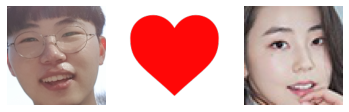

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.imshow(face)
plt.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(heart)
plt.axis('off')

ax = fig.add_subplot(1,3,3)
celebrity = face_find_crop('./data/'+top_5[0][0]+'.jpg')
ax.imshow(celebrity)
plt.axis('off')
plt.show()

**추가사항**

`embedding_dict`를 계산하는 코드에서 생각보다 시간이 많이 걸린다. <br/>
이는 embedding_dict를 저장하는 코드 몇줄이면 손쉽게 해결할 수 있다. <br/>
바로 pickle을 이용해서 객체를 저장하는 방법이다.

`get_face_embedding_dict` 함수 마지막 부분에 추가

In [ ]:
def get_face_embedding_dict(face_dir):
    ----
    ----
    ---
    with open('embedding_dict.pkl', 'wb')as f:
        pickle.dump(embedding_dict, f)
    return embedding_dict

함수 호출 부분에 Pickle로 데이터를 읽는 코드 추가

In [ ]:
if os.path.isfile('embedding_dict.pkl'):
    with open('embedding_dict.pkl', 'rb') as f:
        embedding_dict = pickle.load(f)
else:
    embedding_dict = get_face_embedding_dict(base_dir)

### 마무리

어떻게 하면 코드를 조금이라도 더 깔끔하게 작성할 수 있을까? 고민하는 시간을 가졌던 노드다. 특히 예외처리 하는 부분에서 코드의 욕심이 났다. (몇몇 마음에 안드는 코드들이 존재한다 ㅠㅠ + 코드리뷰좀 해주세요) 

처음 노드를 접했을 때 어떻게 얼굴을 유사도를 판별할 수 있을까? 고민해봤었는데 픽셀들간의 어떠한 연산을 해도 힘들겠다고 생각했지만 `encoding`이라는 기법과 `L2 norm`을 통해 꽤 괜찮은 결과를 얻을 수 있었다.